<a href="https://colab.research.google.com/github/Ahmedanwersaber/AhmedAnwer.com/blob/main/Copy_of_HateSpeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [196]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [197]:
train_file_path = "/content/arHateDataset (1).csv"
test_file_path = "/content/OSACT2020-sharedTask-train.txt"

In [198]:
import re
import string
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, roc_curve, classification_report

In [199]:
df_train  = pd.read_csv(test_file_path,sep="\t",header=None)
df_train.columns =  ["Tweet","Offensive","Hate"]

In [200]:
df_train

,Tweet,Offensive,Hate
0,الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم...,NOT_OFF,NOT_HS
1,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,NOT_OFF,NOT_HS
2,RT @USER: يا رب يا واحد يا أحد بحق يوم الاحد ا...,OFF,HS
3,RT @USER: #هوا_الحرية يا وجع قلبي عليكي يا امي...,NOT_OFF,NOT_HS
4,يا بكون بحياتك الأهم يا إما ما بدي أكون 🎼,NOT_OFF,NOT_HS
...,...,...,...
6834,@USER يا حمار ، يا جاهل ، نسبة الباطل ما بتتحس...,OFF,NOT_HS
6835,RT @USER: @USER كل زق يا طاقية يا واطي يا حقير...,OFF,NOT_HS
6836,@USER<LF>يا كبير يا ممتع يا نجم لابد أن تعي جي...,NOT_OFF,NOT_HS
6837,يا رب الاتحاد يفوز يا رب. 😭😭 #الاتحاد_النصر,NOT_OFF,NOT_HS


In [201]:
df_dev  = pd.read_csv(test_file_path,sep="\t",header=None)
df_dev.columns =  ["Tweet","Offensive","Hate"]

In [202]:
df_dev

,Tweet,Offensive,Hate
0,الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم...,NOT_OFF,NOT_HS
1,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,NOT_OFF,NOT_HS
2,RT @USER: يا رب يا واحد يا أحد بحق يوم الاحد ا...,OFF,HS
3,RT @USER: #هوا_الحرية يا وجع قلبي عليكي يا امي...,NOT_OFF,NOT_HS
4,يا بكون بحياتك الأهم يا إما ما بدي أكون 🎼,NOT_OFF,NOT_HS
...,...,...,...
6834,@USER يا حمار ، يا جاهل ، نسبة الباطل ما بتتحس...,OFF,NOT_HS
6835,RT @USER: @USER كل زق يا طاقية يا واطي يا حقير...,OFF,NOT_HS
6836,@USER<LF>يا كبير يا ممتع يا نجم لابد أن تعي جي...,NOT_OFF,NOT_HS
6837,يا رب الاتحاد يفوز يا رب. 😭😭 #الاتحاد_النصر,NOT_OFF,NOT_HS


In [203]:
df_train['Hate'].value_counts()

NOT_HS    6489
HS         350
Name: Hate, dtype: int64

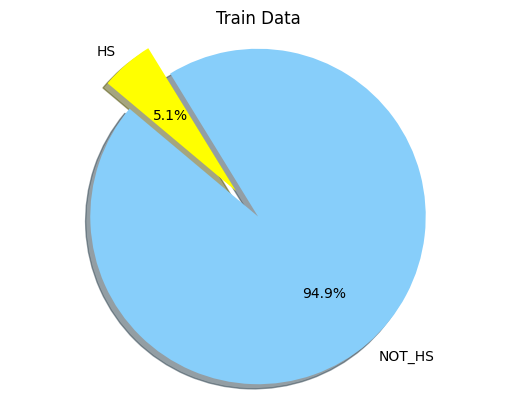

In [204]:
# Data to plot
labels = 'NOT_HS', 'HS'
sizes = [df_train['Hate'].value_counts()[0], df_train['Hate'].value_counts()[1]]
colors = ['lightskyblue', 'yellow']
explode = (0,0.2)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title("Train Data")
plt.show()

In [205]:
df_dev['Hate'].value_counts()

NOT_HS    6489
HS         350
Name: Hate, dtype: int64

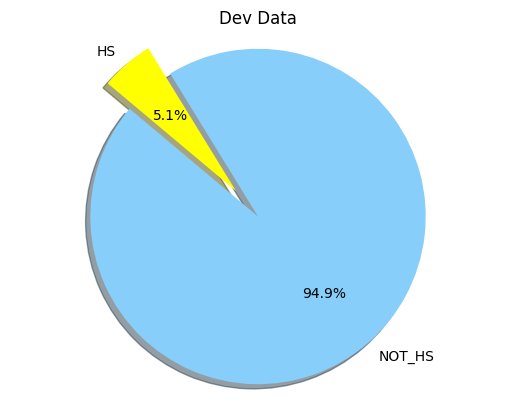

In [206]:
# Data to plot
labels = 'NOT_HS', 'HS'
sizes = [df_dev['Hate'].value_counts()[0], df_dev['Hate'].value_counts()[1]]
colors = ['lightskyblue', 'yellow']
explode = (0,0.2)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title("Dev Data")
plt.show()

In [207]:
def clean(df):
    df = remove_diacritics(df)
    df = remove_punctuations(df)
    df = remove_repeating_char(df)
    df = normalize_arabic(df)
    df = remove_english_word_and_numbers(df)
    df = clean_space(df)
    return df

In [208]:
arabic_punctuations = '''`÷« »×؛<>٩٨'٧٦٥٤٣٢١٠_()↗*•&^%][ـ،/:"؟.,'{}⋮≈~¦+|٪!”…“–ـ/[]%=#*+\\•~@£·_{}©^®`→°€™›♥←×§″′Â█à…“★”–●â►−¢¬░¶↑±▾	═¦║―¥▓—‹─▒：⊕▼▪†■’▀¨▄♫☆é¯♦¤▲è¸Ã⋅‘∞∙）↓、│（»，♪╩╚³・╦╣╔╗▬❤ïØ¹≤‡₹´'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)


In [209]:
def remove_diacritics(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_diacritics(x))
    return df
def _remove_diacritics(x):
    x = str(x)
    x = re.sub(arabic_diacritics, '', x)
    return x

def normalize_arabic(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _normalize_arabic(x))
    return df
def _normalize_arabic(x):
    x = str(x)
    # added space around puncts after replace
    x = re.sub("[إأآا]", "ا", x)
    x = re.sub("ى", "ي", x)
    x = re.sub("ؤ", "ء", x)
    x = re.sub("ئ", "ء", x)
    x = re.sub("ة", "ه", x)
    x = re.sub("گ", "ك", x)
    return x

def remove_punctuations(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_punctuations(x))
    return df
def _remove_punctuations(x):
    x = str(x)
    #translator = str.maketrans(' ', ' ', punctuations_list)
    translator = str.maketrans(punctuations_list, ' '*len(punctuations_list))
    return x.translate(translator)

def remove_repeating_char(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_repeating_char(x))
    return df
def _remove_repeating_char(x):
    x = str(x)
    return re.sub(r'(.)\1+', r'\1', x)

def remove_english_word_and_numbers(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_english_word_and_numbers(x))
    return df
def _remove_english_word_and_numbers(x):
    x = str(x)
    return re.sub(r'[a-zA-Z0-9]+', '', x)

def clean_space(df):
    compiled_re = re.compile(r"\s+")
    df['Tweet'] = df["Tweet"].apply(lambda x: _clean_space(x, compiled_re))
    return df
def _clean_space(x, compiled_re):
    return compiled_re.sub(" ", x)


In [210]:
train_data = pd.DataFrame(clean(df_train))

In [211]:
train_data

,Tweet,Offensive,Hate
0,الحمدله يارب فوز مهم يا زمالك كل الدعم ليكم يا...,NOT_OFF,NOT_HS
1,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,NOT_OFF,NOT_HS
2,يا رب يا واحد يا احد بحق يوم الاحد ان تهلك بن...,OFF,HS
3,هوا الحريه يا وجع قلبي عليكي يا امي اله لا يح...,NOT_OFF,NOT_HS
4,يا بكون بحياتك الاهم يا اما ما بدي اكون 🎼,NOT_OFF,NOT_HS
...,...,...,...
6834,يا حمار يا جاهل نسبه الباطل ما بتحسبش و عاملي...,OFF,NOT_HS
6835,كل زق يا طاقيه يا واطي يا حقير يا تافه يا ساف...,OFF,NOT_HS
6836,يا كبير يا متع يا نجم لابد ان تعي جيدا انا ما...,NOT_OFF,NOT_HS
6837,يا رب الاتحاد يفوز يا رب 😭 الاتحاد النصر,NOT_OFF,NOT_HS


In [212]:
test_data = pd.DataFrame(clean(df_dev))

In [213]:
test_data

,Tweet,Offensive,Hate
0,الحمدله يارب فوز مهم يا زمالك كل الدعم ليكم يا...,NOT_OFF,NOT_HS
1,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,NOT_OFF,NOT_HS
2,يا رب يا واحد يا احد بحق يوم الاحد ان تهلك بن...,OFF,HS
3,هوا الحريه يا وجع قلبي عليكي يا امي اله لا يح...,NOT_OFF,NOT_HS
4,يا بكون بحياتك الاهم يا اما ما بدي اكون 🎼,NOT_OFF,NOT_HS
...,...,...,...
6834,يا حمار يا جاهل نسبه الباطل ما بتحسبش و عاملي...,OFF,NOT_HS
6835,كل زق يا طاقيه يا واطي يا حقير يا تافه يا ساف...,OFF,NOT_HS
6836,يا كبير يا متع يا نجم لابد ان تعي جيدا انا ما...,NOT_OFF,NOT_HS
6837,يا رب الاتحاد يفوز يا رب 😭 الاتحاد النصر,NOT_OFF,NOT_HS


In [214]:
x_train=train_data.iloc[:,0]
y_train=train_data.iloc[:,2]

label_mapping = {'HS': 1, 'NOT_HS': 0}

# Convert training labels
y_train = y_train.map(label_mapping)

In [215]:
# Vectorize training data
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

In [216]:
target_class = 0
oversampling_ratio = {target_class: 3645}
ros = RandomUnderSampler(sampling_strategy=oversampling_ratio, random_state=42)
x_resampled, y_resampled = ros.fit_resample(X_train_tfidf, y_train)

labels_hate = y_resampled.values
class_names = np.unique(labels_hate)
class_weights = compute_class_weight(class_weight = "balanced", classes = class_names, y = labels_hate)

In [217]:
print(y_resampled.value_counts())

0    3645
1     350
Name: Hate, dtype: int64


In [218]:
class_weights = dict(zip(np.unique(labels_hate), class_weights))
print(class_weights)

{0: 0.5480109739368999, 1: 5.707142857142857}


In [219]:
# Train SVM classifier with class weights
clf = SVC(random_state=0, class_weight={class_names[0]: class_weights[0], class_names[1]: class_weights[1]})
clf.fit(x_resampled, y_resampled)

SVC(class_weight={0: 0.5480109739368999, 1: 5.707142857142857}, random_state=0)

In [220]:
x_test=test_data.iloc[:,0]
y_test=test_data.iloc[:,2]

label_mapping = {'HS': 1, 'NOT_HS': 0}

y_test = y_test.map(label_mapping)

In [221]:
# Vectorize test data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(x_test)

In [222]:
# Make predictions
y_pred = clf.predict(X_test_tfidf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6489
           1       0.99      1.00      0.99       350

    accuracy                           1.00      6839
   macro avg       0.99      1.00      1.00      6839
weighted avg       1.00      1.00      1.00      6839


Macro F1: 99.70%
Accuracy: 99.94%
Macro Precision: 99.44%
Macro Recall: 99.97%


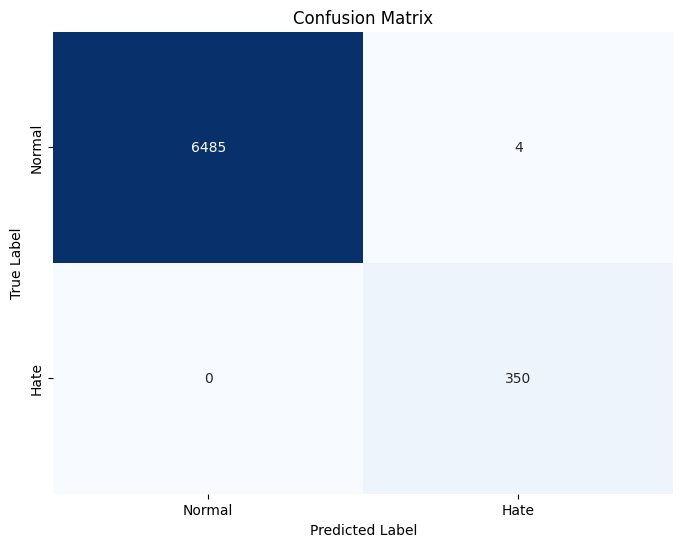

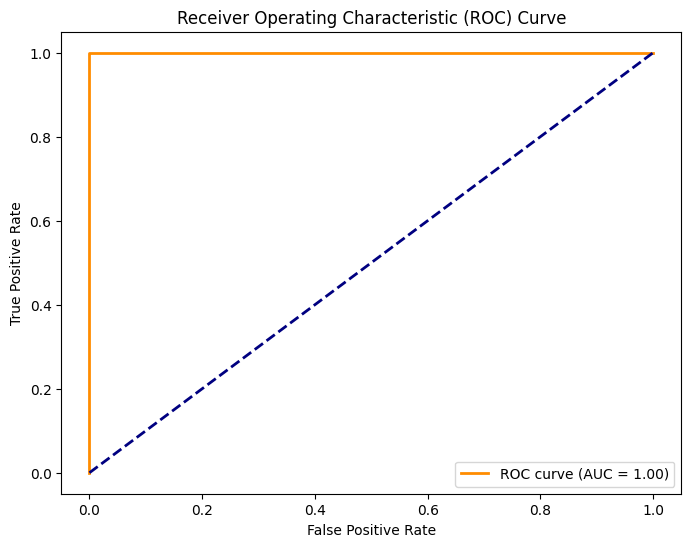

In [223]:
print(metrics.classification_report(y_test, y_pred))

macro_f1 = f1_score(y_test, y_pred,average='macro')
macro_precision = precision_score(y_test, y_pred,average='macro')
macro_recall = recall_score(y_test, y_pred,average='macro')
acc = accuracy_score(y_test, y_pred)

print(f"\nMacro F1: {macro_f1 * 100:.2f}%")
print(f"Accuracy: {acc * 100:.2f}%")
print(f"Macro Precision: {macro_precision * 100:.2f}%")
print(f"Macro Recall: {macro_recall * 100:.2f}%")

# Output the confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal', 'Hate'], yticklabels=['Normal', 'Hate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Predicted probabilities
y_pred_proba = clf.decision_function(X_test_tfidf)

# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Logistic Regression Classifier


In [224]:
from sklearn import linear_model

In [225]:
LR= linear_model.LogisticRegression()
LR.fit(X_train_tfidf, y_pred)
LR.score(X_train_tfidf,y_pred)

0.9483842667056587

In [226]:
x_pred=test_data.iloc[:,0]
y_test=test_data.iloc[:,2]
X=x_test.to_dict()

X=[]
for d in range(len(X)):
    b=X[d].lower()
    X.append(b)
    y_test_tfidf=count_vect.transform(x_test)
    y_pred=LR.predict(X_test_tfidf)

In [227]:
from sklearn.metrics import classification_report as creport



In [228]:
# Assuming X_test and y_pred are defined elsewhere in the code
print(creport(y_train, y_pred,target_names=['HS', 'NOT_HS'],digits=4))

              precision    recall  f1-score   support

          HS     1.0000    0.9994    0.9997      6489
      NOT_HS     0.9887    1.0000    0.9943       350

    accuracy                         0.9994      6839
   macro avg     0.9944    0.9997    0.9970      6839
weighted avg     0.9994    0.9994    0.9994      6839



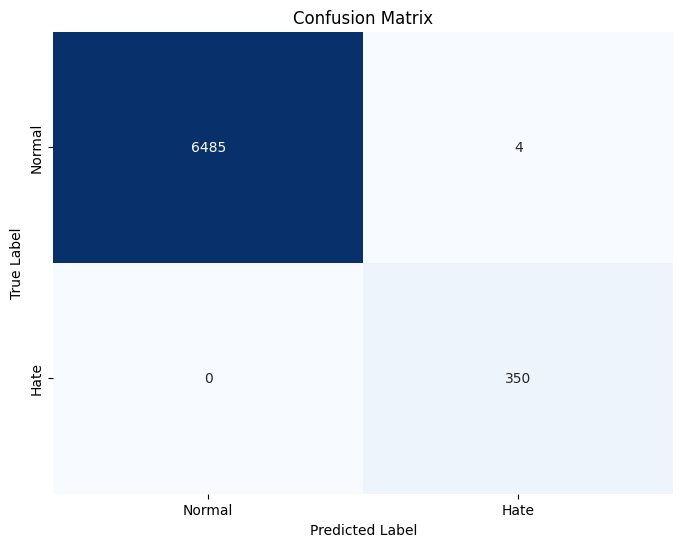

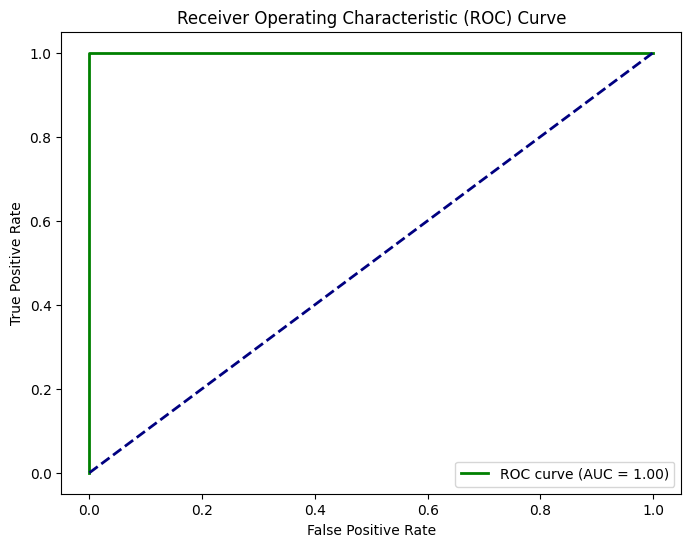

In [229]:
# Output the confusion matrix
conf_matrix = metrics.confusion_matrix(y_train, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal', 'Hate'], yticklabels=['Normal', 'Hate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Predicted probabilities
y_pred_proba = clf.decision_function(X_train_tfidf)

# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_train, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Random Forest Classifier



In [230]:
from sklearn import model_selection, naive_bayes, svm, ensemble, tree
from xgboost import XGBClassifier

In [231]:
RF= ensemble.RandomForestClassifier()
RF.fit(X_train_tfidf,y_pred)
RF.score(X_train_tfidf,y_pred)

1.0

In [232]:
x_pred=test_data.iloc[:,0]
y_test=test_data.iloc[:,2]
X=x_test.to_dict()

X=[]
for d in range(len(X)):
    b=X[d].lower()
    X.append(b)
    y_test_tfidf=count_vect.transform(x_test)
    y_pred=LR.predict(X_test_tfidf)

In [233]:
print(creport(y_train, y_pred,target_names=['HS', 'NOT_HS'] ,digits=4))

              precision    recall  f1-score   support

          HS     1.0000    0.9994    0.9997      6489
      NOT_HS     0.9887    1.0000    0.9943       350

    accuracy                         0.9994      6839
   macro avg     0.9944    0.9997    0.9970      6839
weighted avg     0.9994    0.9994    0.9994      6839



## naive bayes Classifier

## MultinomialNB

In [234]:
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

In [235]:
data = pd.read_csv('arHateDataset (1).csv')

In [236]:
data = clean(data)

In [237]:
data['Class'].value_counts()

0    22789
1    10951
Name: Class, dtype: int64

In [238]:
x= data['Tweet']
y=data['Class']

In [239]:
# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [240]:
#tfidf_vectorizer = TfidfVectorizer(ngram_range=(3, 3))
#tfidf_vectorizer = CountVectorizer(ngram_range=(3, 3))
tfidf_vectorizer = TfidfVectorizer(min_df=0.0001, max_df=0.95)
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [241]:
# Create the Naive Bayes model
model = MultinomialNB()

In [242]:
# Train the model (reshape text data for MultinomialNB)
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [243]:
# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)


Macro F1: 80.26%
Accuracy: 84.81%
Macro Precision: 89.07%
Macro Recall: 77.45%


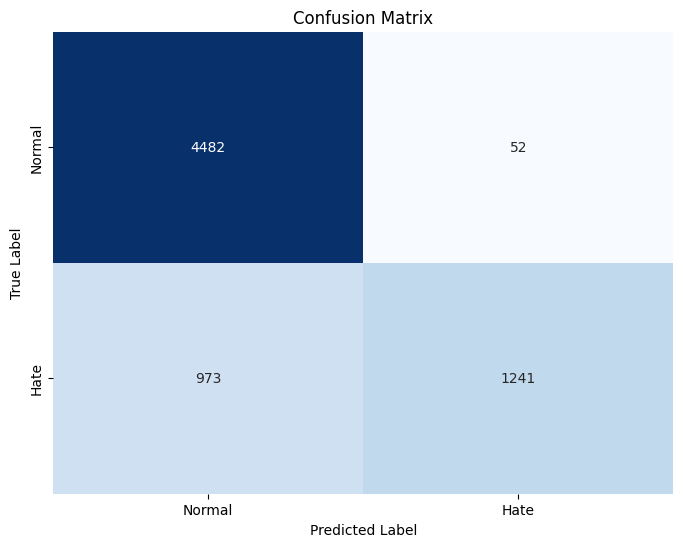

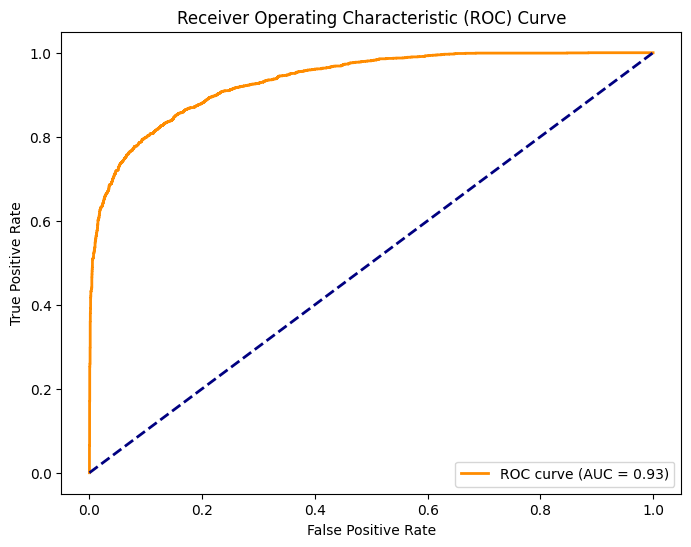

In [244]:
macro_f1 = f1_score(y_test, y_pred,average='macro')
macro_precision = precision_score(y_test, y_pred,average='macro')
macro_recall = recall_score(y_test, y_pred,average='macro')
acc = accuracy_score(y_test, y_pred)

print(f"\nMacro F1: {macro_f1 * 100:.2f}%")
print(f"Accuracy: {acc * 100:.2f}%")
print(f"Macro Precision: {macro_precision * 100:.2f}%")
print(f"Macro Recall: {macro_recall * 100:.2f}%")

# Output the confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal', 'Hate'], yticklabels=['Normal', 'Hate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
# Predicted probabilities
y_pred_proba = model.predict_proba(X_test_tfidf)

# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba[:,1])
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## BernoulliNB


In [245]:
from sklearn.feature_extraction.text import CountVectorizer

In [246]:
#tfidf_vectorizer = TfidfVectorizer(ngram_range=(3, 3))
#tfidf_vectorizer = CountVectorizer(ngram_range=(3, 3))
tfidf_vectorizer = TfidfVectorizer(min_df=0.0001, max_df=0.95)
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [247]:
# Create the Naive Bayes model
#model = MultinomialNB()
model = BernoulliNB()

In [248]:
# Train the model (reshape text data for MultinomialNB)
model.fit(X_train_tfidf, y_train)

BernoulliNB()

In [249]:
# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)


Macro F1: 85.03%
Accuracy: 86.48%
Macro Precision: 84.37%
Macro Recall: 85.91%


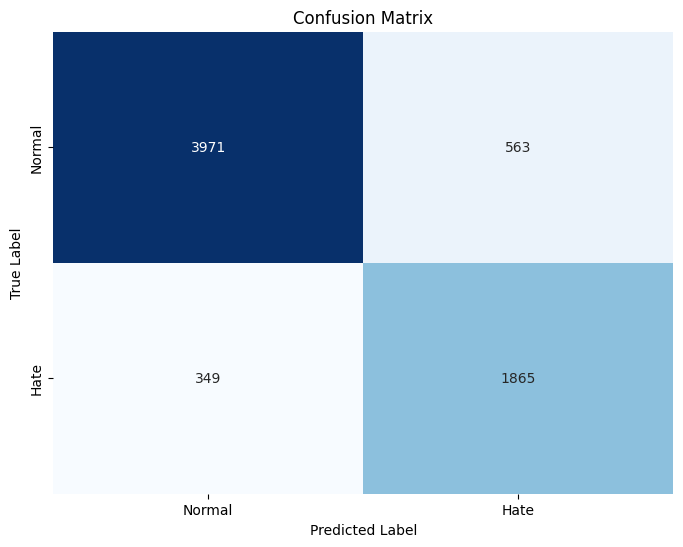

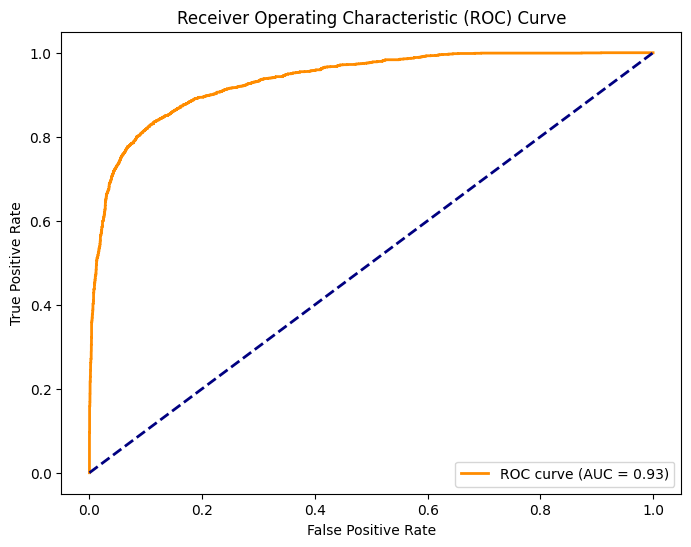

In [250]:
macro_f1 = f1_score(y_test, y_pred,average='macro')
macro_precision = precision_score(y_test, y_pred,average='macro')
macro_recall = recall_score(y_test, y_pred,average='macro')
acc = accuracy_score(y_test, y_pred)

print(f"\nMacro F1: {macro_f1 * 100:.2f}%")
print(f"Accuracy: {acc * 100:.2f}%")
print(f"Macro Precision: {macro_precision * 100:.2f}%")
print(f"Macro Recall: {macro_recall * 100:.2f}%")

# Output the confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal', 'Hate'], yticklabels=['Normal', 'Hate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Predicted probabilities
y_pred_proba = model.predict_proba(X_test_tfidf)

# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba[:,1])
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# KNN


In [251]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.pipeline import Pipeline





In [252]:
#tfidf_vectorizer = TfidfVectorizer(ngram_range=(3, 3))
#tfidf_vectorizer = CountVectorizer(ngram_range=(3, 3))
tfidf_vectorizer = TfidfVectorizer(min_df=0.0001, max_df=0.95)
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [253]:
KN= KNeighborsClassifier()
KN.fit(X_train_tfidf, y_train)


KNeighborsClassifier()

In [254]:
# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)


Macro F1: 85.03%
Accuracy: 86.48%
Macro Precision: 84.37%
Macro Recall: 85.91%


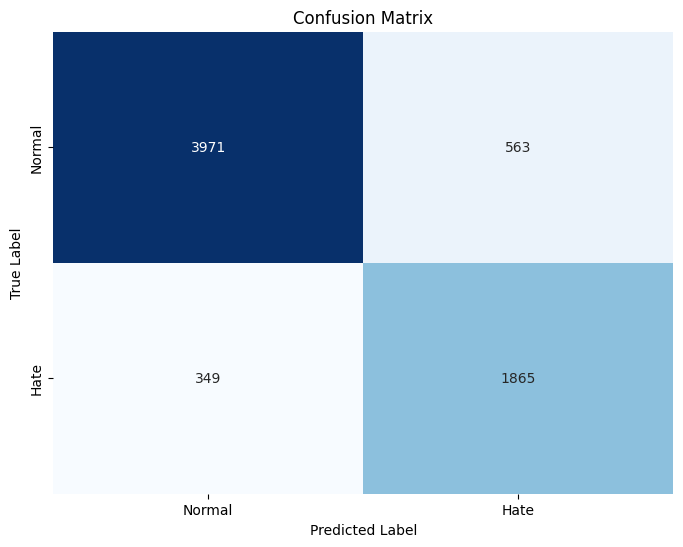

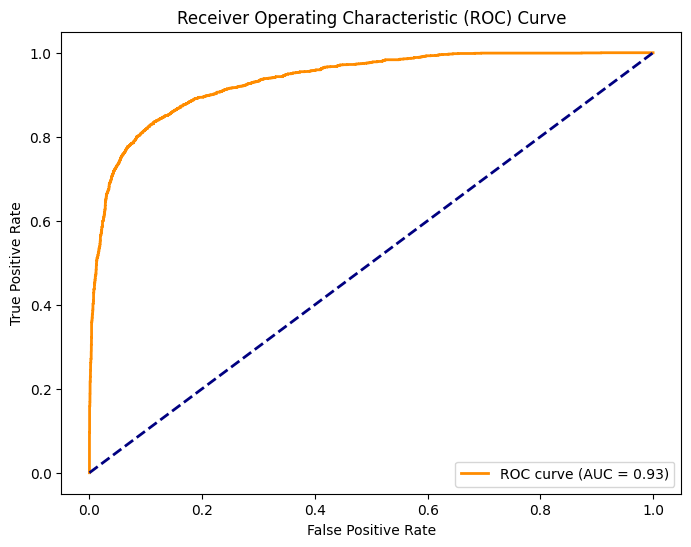

In [255]:
macro_f1 = f1_score(y_test, y_pred,average='macro')
macro_precision = precision_score(y_test, y_pred,average='macro')
macro_recall = recall_score(y_test, y_pred,average='macro')
acc = accuracy_score(y_test, y_pred)

print(f"\nMacro F1: {macro_f1 * 100:.2f}%")
print(f"Accuracy: {acc * 100:.2f}%")
print(f"Macro Precision: {macro_precision * 100:.2f}%")
print(f"Macro Recall: {macro_recall * 100:.2f}%")

# Output the confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal', 'Hate'], yticklabels=['Normal', 'Hate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Predicted probabilities
y_pred_proba = model.predict_proba(X_test_tfidf)

# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba[:,1])
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()